Выберите режим селекции - '1' для пропорциональной или '2' для турнирной 1



Размер популяции: 10
Режим селекции: пропорциональная 
fit: [-3.32983527 -2.9174687   4.70180562 -7.17775607  4.56897804  1.90138975
 -5.16069008  3.68602199  4.0239652   4.52316945]

['0100001100', '1100000000', '1110000101', '0010111010', '1100110101', '1011010001', '1101011110', '1100101101', '1100101111', '0011111010']

1
1
2
0
2
1
0
1
1
2


new: ['0100001100', '1100000000', '1110000101', '1110000101', '1100110101', '1100110101', '1011010001', '1100101101', '1100101111', '0011111010', '0011111010']

fit: [ 1.1146252  -3.63300922  4.70180562  4.56897804 -3.19727261  5.22710723
  4.70180562  3.68602199  1.72446695  7.64731961]

['0100110100', '1100001100', '1110000101', '1100110101', '1100000010', '0011111000', '1110000101', '1100101101', '0111111010', '0000101111']

1
0
1
1
0
1
1
1
1
2


new: ['0100110100', '1110000101', '1100110101', '0011111000', '1110000101', '1100101101', '0111111010', '0000101111', '0000101111']

fit: [  6.51047209   5.22710723 -10.27237998  -0.88146251   6.36

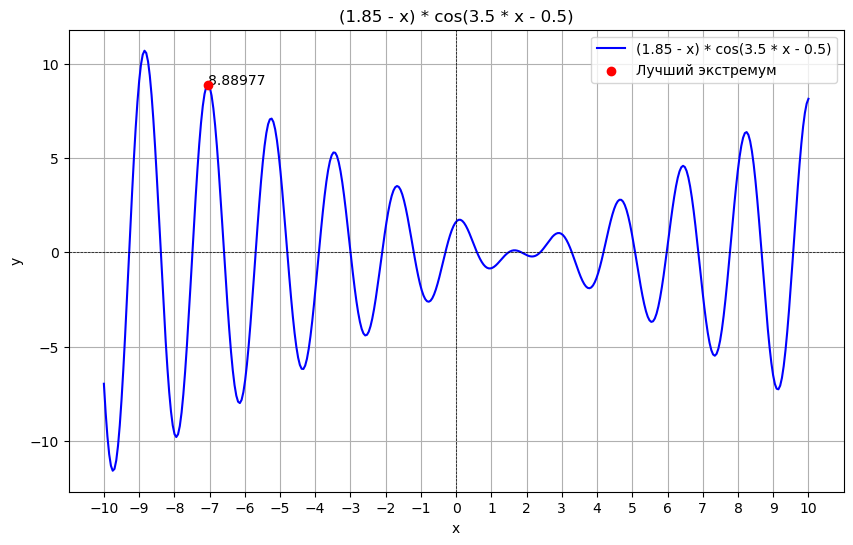

In [253]:
import math
import random
import numpy as np
import time
import matplotlib.pyplot as plt

population_size = 10
# generations = 50
mutation_rate = 0.5
chromosome_length = 10
crossover_prob = 0.9
h = 0.02
best = {'chromosome': None,'fitness': -float('inf')}
max_stagnation = 50
target = 10.686
epsilon = 0.01

def fitness(x):
    return (1.85 - x) * np.cos(3.5 * x - 0.5)

def encode(x):
    k = int(round((x + 10) / h))
    return format(k, f'0{chromosome_length}b')

def decode(chromosome):
    k = int(chromosome,2)
    return k * 0.02 - 10

def init_population():
    return [encode(random.uniform(-10,10)) for _ in range(population_size)]

def mean_fitness_selection(population, fitnesses=None):
    if (fitnesses is None):
        fitnesses = [fitness(decode(chromosome)) for chromosome in population]
    min_fit = min(fitnesses)
    offset = abs(min_fit) + 1e-6 if min_fit < 0 else 0
    fitnesses = [fit + offset for fit in fitnesses]
    f_mean = sum(fitnesses) / len(fitnesses)
    new_population = []
    print(f'{population}\n')
    for ind, fit in zip(population, fitnesses):
        print(round(fit / f_mean))
        copies = 1 if f_mean == 0 else round(fit / f_mean)
        copies = max(copies, 0)
        new_population.extend([ind] * copies)
    print("\n")
    print(f'new: {new_population}\n')
    if len(new_population) > population_size:
        new_population = random.sample(new_population, population_size)
    elif len(new_population) < population_size:
        while len(new_population) < population_size:
            new_population.append(random.choice(population))
    return new_population

def tournament_selection(population,fitnesses):
    fitnesses = np.array(fitnesses)
    tournament = (random.sample(population,3))
    tournament  = np.array([[x, fitness(round(decode(x),2)) ] for x in tournament])
    max_index = np.argmax(tournament[:,1])
    return tournament[max_index,0]  
def selection(population, fitnesses=None):
    if (fitnesses is None):
        fitnesses = [fitness(decode(chromosome)) for chromosome in population]
    if mode == '1': 
        return mean_fitness_selection(population,fitnesses)
    elif mode == '2':
        return tournament_selection(population,fitnesses)

def crossover(parent1, parent2):
    if (random.random() < crossover_prob):
        point = random.randint(1, chromosome_length-1)
        return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]
    return parent1, parent2


def mutation(chromosome):
    if random.random() < mutation_rate:
        pos = random.randint(0, chromosome_length-1)
        return chromosome[:pos] + ('0' if chromosome[pos] == '1' else '1') + chromosome[pos+1:]
    return chromosome

def shift_fitnesses(fitnesses):
    f_min = min(fitnesses)
    if f_min < 0:
        fitnesses = np.array([f - f_min + 1e-6 for f in fitnesses])
    return fitnesses

population = init_population()
counter = 0
mode = input("Выберите режим селекции - '1' для пропорциональной или '2' для турнирной")
print(f"\nРазмер популяции: {population_size}\nРежим селекции: {'пропорциональная' if mode == '1' else 'турнирная'} ")
start_time = time.time()
while True:
    fitnesses = np.array([fitness(decode(chromosome)) for chromosome in population])
    print(f'fit: {fitnesses}\n')
    max_index = np.argmax(fitnesses)
    best_x = fitnesses[max_index]
    best_chromo = population[max_index]
   
    # print(f"Поколение {counter+1}:  Лучший x = {best_x:.10f}")
    if best_x > best['fitness']:
        best['fitness'] = best_x
        best['chromo'] = best_chromo
        stagnation_counter = 0
    else:
        stagnation_counter += 1

    if (target is not None and 
        abs(best['fitness'] - target) <= epsilon) or (best['fitness'] > target):
        print(f"Достигнута целевая точность ±{epsilon:.4f}")
        print(f'Прошло: {counter+1} поколений')
        break
        
    if stagnation_counter >= max_stagnation:
        print(f"Остановка: целевое значение {target} не было достигнуто, нет улучшений {max_stagnation} поколений")
        print(f'Прошло: {counter+1} поколений')
        break
    new_population = []
    if mode == '1':
        mating_pool = mean_fitness_selection(population, fitnesses)
        while len(mating_pool) >= 2:
            i = random.randint(0, len(mating_pool) - 1)
            parent1 = mating_pool.pop(i)
            j = random.randint(0, len(mating_pool) - 1)
            parent2 = mating_pool.pop(j)
            child1, child2 = crossover(parent1,parent2)
            child1 = mutation(child1)
            child = mutation(child2)
            new_population.extend([child1, child2])
        population = new_population[:population_size]
    elif mode == '2':
        for i in range (0,population_size,2):
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            child1, child2 = crossover(parent1,parent2)
            child1 = mutation(child1)
            child2 = mutation(child2)
            new_population.extend([child1,child2])
        population = new_population
    counter += 1

    
end_time = time.time()
print(f"\nМаксимум найден в x = {decode(best['chromo'])}")
print(f"Значение функции f(x) = {best['fitness']:.10f}")
print(f'Время выполнения: {end_time - start_time:.2f}с')
plt.figure(figsize=(10,6))
x = np.linspace(-10,10,400)
y = fitness(x)
plt.plot(x,y, color='blue',label='(1.85 - x) * cos(3.5 * x - 0.5)')
plt.title('(1.85 - x) * cos(3.5 * x - 0.5)')
plt.scatter(decode(best['chromo']),best['fitness'], color='red', label='Лучший экстремум',zorder=5)
plt.text(decode(best['chromo']),best['fitness'], round(best['fitness'],5))
plt.xticks([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10])
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(0,color='black', lw=0.5, ls='--')
plt.axvline(0,color='black', lw=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()

## 


Размер популяции: 20
Режим селекции: пропорциональная 
Достигнута целевая точность ±0.0100
Прошло: 12 поколений

Максимум найден в x = -8.84
Значение функции f(x) = 10.6869025528
Время выполнения: 0.01с


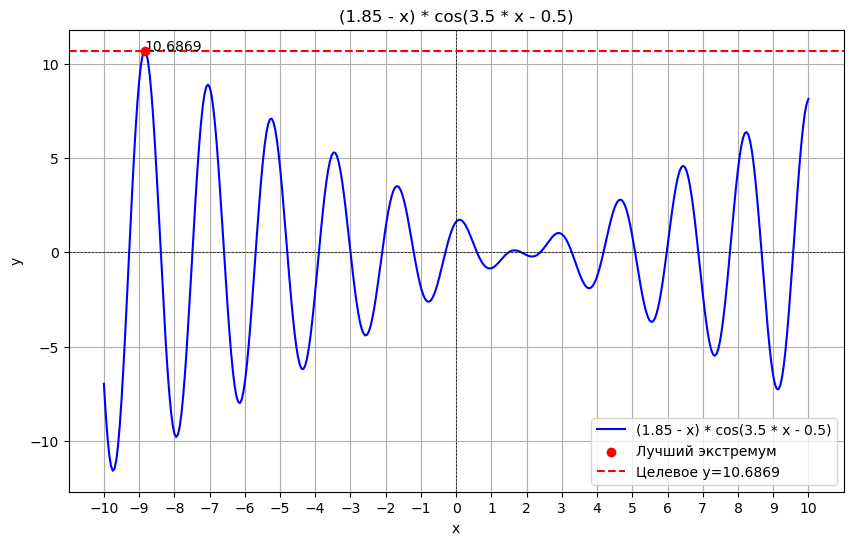

In [352]:
import math
import random
import numpy as np
import time
import matplotlib.pyplot as plt

class Chromosome:
    def __init__(self,length=10,range=(-10,10),h=0.02,mutation_rate=0.1):
        self.mutation_rate = mutation_rate
        self.length = math.ceil(math.log2(abs(range[1] - range[0]) / h + 1))
        self.h = h
        # self.decodedDNA = random.uniform(*range)
        self.DNA = self.encode(random.uniform(*range))

    def __repr__(self):
        return self.DNA
    
    def getFitness(self):
        return (1.85 - self.decode()) * np.cos(3.5 * self.decode() - 0.5)

    def getLength(self):
        return self.length
    
    def encode(self, x):
        k = int(round((x + 10) / self.h))
        return format(k, f'0{self.length}b')

    def decode(self):
        k = int(self.DNA,2)
        return k * h - 10

    def mutate(self):
        if random.random() < self.mutation_rate:
            pos = random.randint(0, self.length-1)
            self.DNA[:pos] + ('0' if self.DNA[pos] == '1' else '1') + self.DNA[pos+1:]
            
    def __str__(self):
        return self.DNA

    def copy(self):
         new_chrom = Chromosome(...) 
         new_chrom.DNA = self.DNA
         return new_chrom
         
class Population:
    def __init__(self, size, h,r, mutation_rate):
        self.size = size
        self.population = [Chromosome(range=r,h=h,mutation_rate=mutation_rate) for _ in range(self.size)]

    def __repr__(self):
        return str(self.population)
        
    def __str__(self):
        return str(self.population)
        
    def set_chromosome_length(self,l):
        self.chromosome_length = l

    def get_chromosome_length(self):
        return self.chromosome_length
        
    def __getitem__(self,index):
        return self.population[index]
        
    def __len__(self):
        return self.size
        
class GeneticAlgorithm:
    def __init__(self, population_size=20, mutation_rate=0.1, crossover_prob=0.9,h=0.02,max_stagnation=50,target=None,epsilon=None, mode=1, range=(-10,10)):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_prob = crossover_prob
        self.h = h
        self.range = range
        self.max_stagnation = max_stagnation
        self.target = target
        self.epsilon = epsilon
        self.mode = mode
        self.best = {}
        self.best['fitness'] = -float('inf')
        self.best['chromo'] = None

    def mean_fitness_selection(self):
        min_fit = min(self.population_fitnesses)
        offset = abs(min_fit) + 1e-6 if min_fit < 0 else 0
        self.population_fitnesses = [fit + offset for fit in self.population_fitnesses]
        f_mean = sum(self.population_fitnesses) / len(self.population_fitnesses)
        new_population = []
        # print(f'{self.population}')
        for ind, fit in zip(self.population, self.population_fitnesses):
            copies = 1 if f_mean == 0 else round(fit / f_mean)
            # print(copies)
            copies = max(copies, 0)
            new_population.extend([ind] * copies)
        # print('\n')
        # print(f'new: {new_population}')
        if len(new_population) > self.population_size:
            new_population = random.sample(new_population, self.population_size)
        elif len(new_population) < self.population_size:
            while len(new_population) < self.population_size:
                new_population.append(random.choice(self.population))
        return new_population

    # def tournament_selection(self):
    #     self.population_fitnesses = np.array(self.population_fitnesses)
    #     tournament = (random.sample(self.population,3))
    #     tournament  = np.array([[x, fitness(round(x,2)) ] for x in tournament])
    #     max_index = np.argmax(tournament[:,1])
    #     return tournament[max_index,0]  

    def crossover(self,parent1,parent2):
        child1 = parent1.copy() 
        child2 = parent2.copy()
        if random.random() < self.crossover_prob:
            point = random.randint(0,parent1.getLength()-1)
            child1.DNA = parent1.DNA[:point] + parent2.DNA[point:]
            child2.DNA = parent2.DNA[:point] + parent1.DNA[point:]
        return child1, child2

    def __get_results(self):
        print(f"\nМаксимум найден в x = {self.best['chromo'].decode()}")
        print(f"Значение функции f(x) = {self.best['fitness']:.10f}")
        print(f'Время выполнения: {self.end_time - self.start_time:.2f}с')
        
    def __create_plot(self):
        plt.figure(figsize=(10,6))
        x = np.linspace(*self.range,400)
        y = fitness(x)
        plt.plot(x,y, color='blue',label='(1.85 - x) * cos(3.5 * x - 0.5)')
        plt.title('(1.85 - x) * cos(3.5 * x - 0.5)')
        plt.scatter(self.best['chromo'].decode(),self.best['fitness'], color='red', label='Лучший экстремум',zorder=5)
        plt.text(self.best['chromo'].decode(),self.best['fitness'], round(self.best['fitness'],5))
        plt.xticks([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.axhline(0,color='black', lw=0.5, ls='--')
        plt.axvline(0,color='black', lw=0.5, ls='--')
        plt.axhline(y=self.target, color='r', linestyle='--', label=f'Целевое y={self.target}')
        plt.legend()
        plt.grid()
        plt.show()

    def run(self):
        self.population = Population(size=self.population_size,h=self.h,r=self.range, mutation_rate=self.mutation_rate)
        self.population.set_chromosome_length(self.population[0].getLength())
        self.counter = 0
        print(f"\nРазмер популяции: {self.population_size}\nРежим селекции: {'пропорциональная' if self.mode == 1 else 'турнирная'} ")
        self.start_time = time.time()
        while True:
            self.population_fitnesses = np.array([chromosome.getFitness() for chromosome in self.population])
            # print(f'fit: {self.population_fitnesses}\n')
            max_index = np.argmax(self.population_fitnesses)
            best_x = self.population_fitnesses[max_index]
            best_chromo = self.population[max_index]
            # print(f"Поколение {self.counter+1}:  Лучший x = {best_x:.10f}")
            if best_x > self.best['fitness']:
                self.best['fitness'] = best_x
                self.best['chromo'] = best_chromo
                self.stagnation_counter = 0
            else:
                self.stagnation_counter += 1

            if (self.target is not None and 
                abs(self.best['fitness'] - self.target) <= self.epsilon) or (self.best['fitness'] > self.target):
                print(f"Достигнута целевая точность ±{self.epsilon:.4f}")
                print(f'Прошло: {self.counter+1} поколений')
                break
        
            if self.stagnation_counter >= self.max_stagnation:
                print(f"Остановка: целевое значение {self.target} не было достигнуто, нет улучшений {self.max_stagnation} поколений")
                print(f'Прошло: {self.counter+1} поколений')
                break

            new_population = []
            if self.mode == 1:
                mating_pool = self.mean_fitness_selection()
                while len(mating_pool) >= 2:
                    i = random.randint(0, len(mating_pool) - 1)
                    parent1 = mating_pool.pop(i)
                    j = random.randint(0, len(mating_pool) - 1)
                    parent2 = mating_pool.pop(j)
                    child1,child2 = self.crossover(parent1,parent2)
                    child1.mutate()
                    child2.mutate()
                    new_population.extend([child1, child2])
                self.population = new_population[:self.population_size]
            # elif self.mode == 2:
            #     for i in range (0,self.population_size,2):
            #         parent1 = self.tournament_selection()
            #         parent2 = self.tournament_selection()
            #         child1, child2 = self.crossover(parent1,parent2)
            #         child2.mutate()
            #         new_population.extend([child1,child2])
            #     self.population = new_population
            self.counter += 1
        self.end_time = time.time()
        self.__get_results()
        self.__create_plot()

gen_alg = GeneticAlgorithm(population_size=20, mutation_rate=0.5, crossover_prob=0.9,h=0.02,max_stagnation=50,target=10.6869,epsilon=0.01, mode=1, range=(-10,10))
gen_alg.run()


# 